In [1]:
import pandas as pd

df = pd.read_csv('./fredupdated.csv', parse_dates=['observation_date'])


df.set_index('observation_date', inplace=True)

df.head(5)

start_date = '1959-01-01'

df = df.loc[start_date:]

df['Inflation_Rate'] = (df['CPIAUCSL'].pct_change(periods=12)) * 100


df.drop(columns=['CPIAUCSL'], inplace=True)


df.head(5)



,UNRATE,GDP,PCE,FEDFUNDS,GS10,M2SL,GDPC1,CIVPART,PPIACO,CES0500000003,Inflation_Rate
observation_date,,,,,,,,,,,
1959-01-01,5.8,510.330,309.5,2.57,3.99,287.8,3352.129,59.2,31.700,NaN,NaN
1959-04-01,5.1,522.653,315.5,3.08,4.26,292.1,3427.667,59.3,31.767,NaN,NaN
1959-07-01,5.3,525.034,320.7,3.58,4.50,296.1,3430.057,59.3,31.667,NaN,NaN
1959-10-01,5.6,528.600,322.9,3.99,4.58,297.1,3439.832,59.3,31.533,NaN,NaN
1960-01-01,5.1,542.648,326.4,3.93,4.49,298.6,3517.181,58.9,31.667,NaN,NaN


In [2]:
df.info()
df.drop(columns=['CES0500000003'], inplace=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1959-01-01 to 2025-01-01
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UNRATE          264 non-null    float64
 1   GDP             264 non-null    float64
 2   PCE             264 non-null    float64
 3   FEDFUNDS        264 non-null    float64
 4   GS10            264 non-null    float64
 5   M2SL            264 non-null    float64
 6   GDPC1           264 non-null    float64
 7   CIVPART         264 non-null    float64
 8   PPIACO          264 non-null    float64
 9   CES0500000003   75 non-null     float64
 10  Inflation_Rate  253 non-null    float64
dtypes: float64(11)
memory usage: 24.8 KB


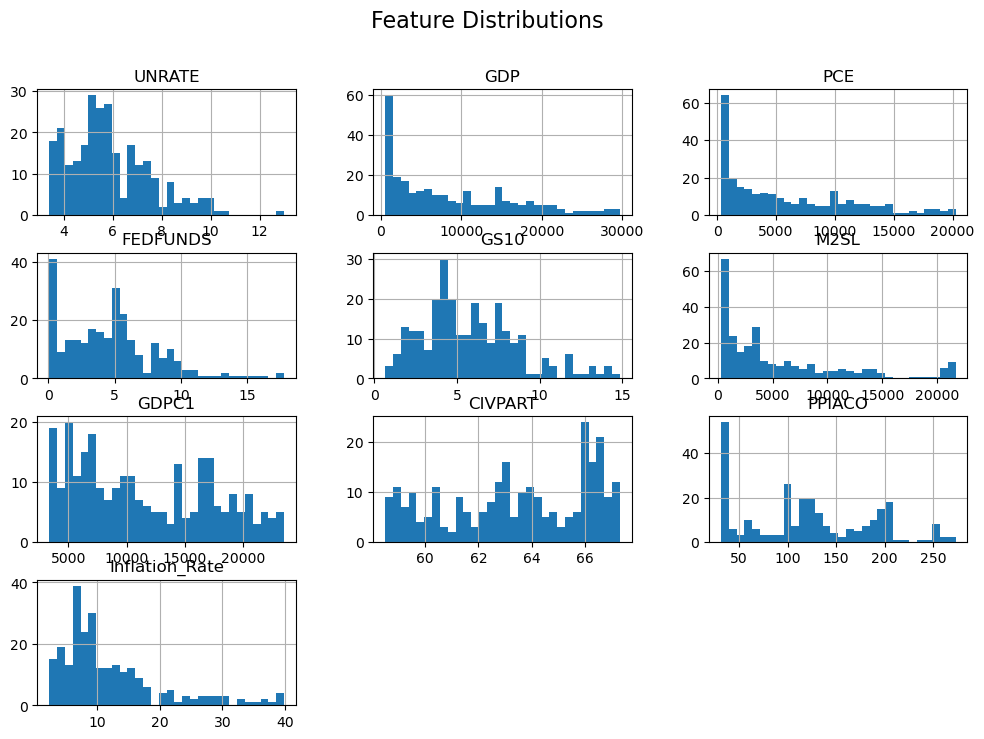

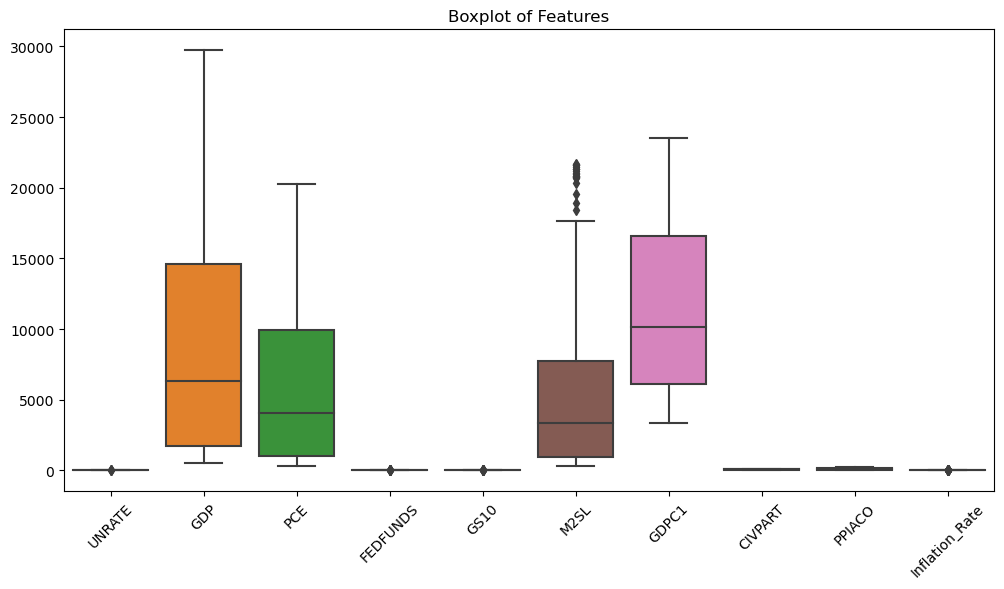

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # Histograms
df.hist(figsize=(12, 8), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplot of Features")
plt.show()


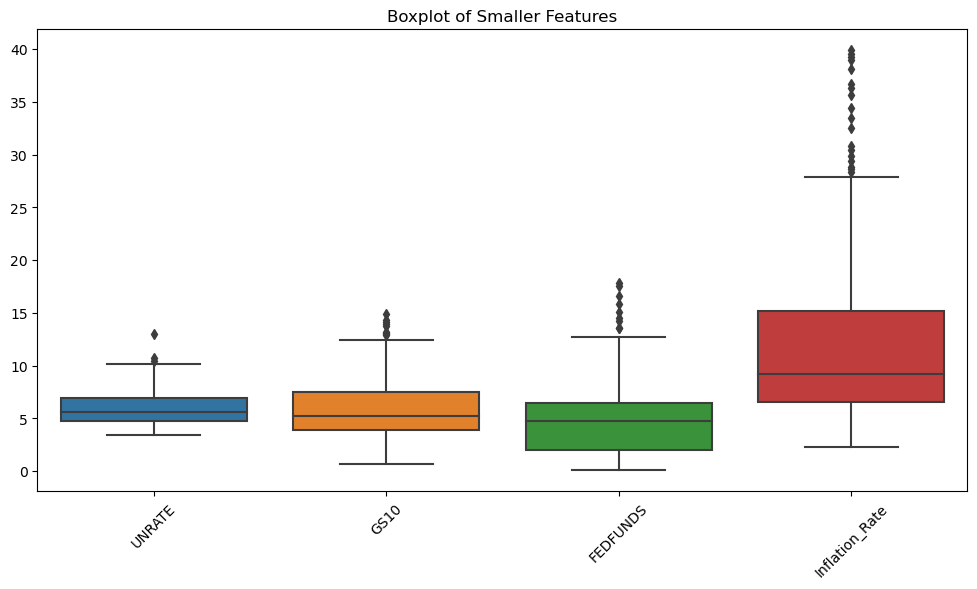

In [43]:


plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['UNRATE', 'GS10', 'FEDFUNDS', 'Inflation_Rate']])
plt.xticks(rotation=45)
plt.title("Boxplot of Smaller Features")
plt.show()

## Data Overview and Preparation

We've loaded economic data from FRED, focusing on inflation rate calculated from the Consumer Price Index (CPIAUCSL). The inflation rate is calculated as the year-over-year percentage change in CPI, which is a standard approach for measuring annual inflation.

Key aspects of our dataset:
- Time period starts from January 1959
- Quarterly


 frequency data
- Inflation rate shows considerable variation over time
- Various economic indicators like unemployment rate (UNRATE), GDP, and federal funds rate (FEDFUNDS) are included for potential modeling

The histograms and box plots reveal that our variables have different scales and distributions, suggesting the need for transformations before modeling.This version of the annual inflation rate

 is calculated by downloading the yearly CPI (vs. monthly as before) and again using the same formula to calculate yearly inflation rate. We note significant differences in calculated vs. actual inflation rates versus the other example.

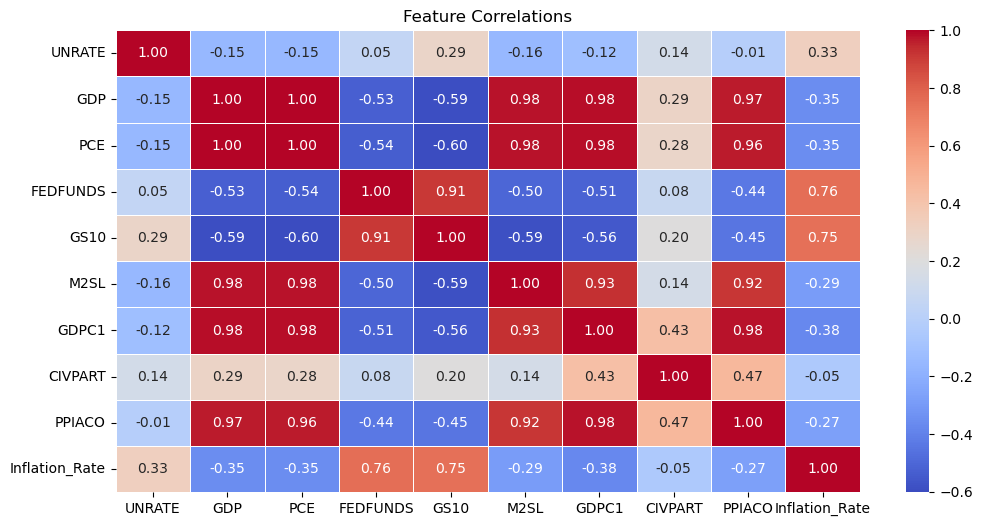

/Users/rayva/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


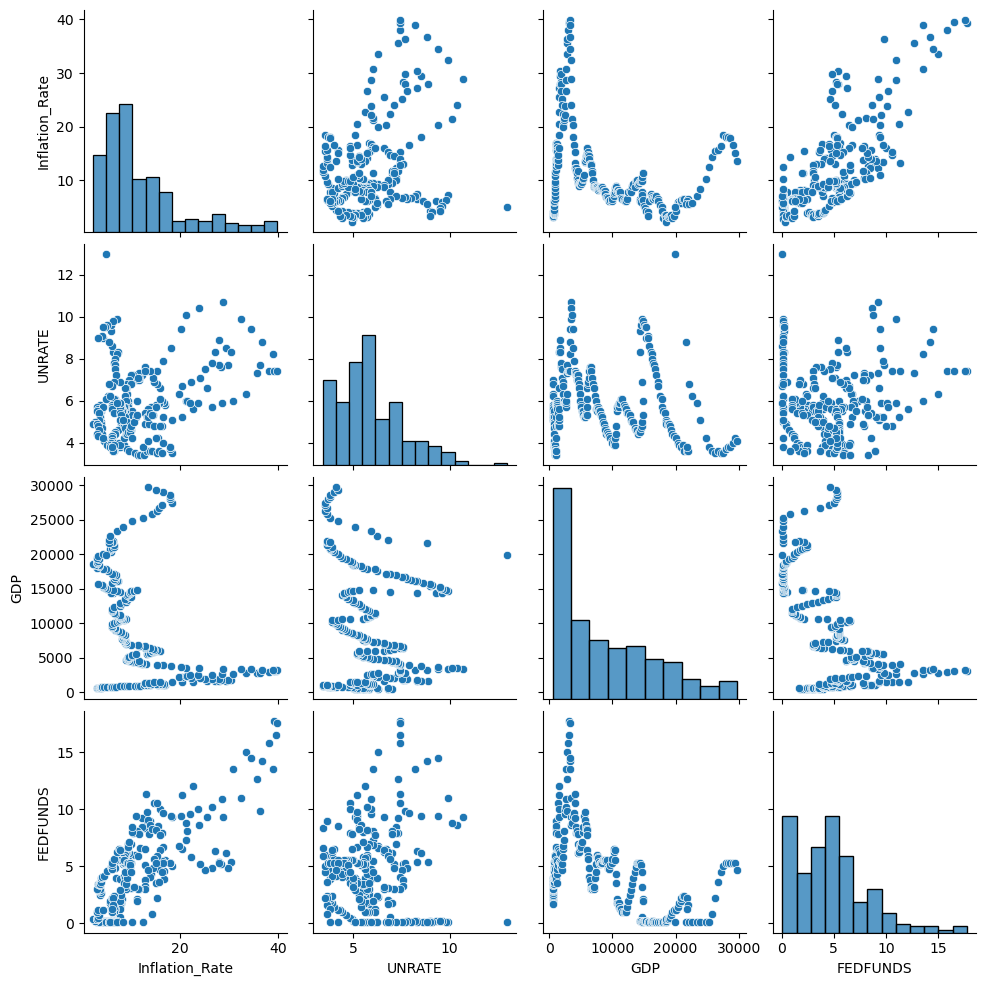

In [4]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlations")
plt.show()

# Plotting only a few right now

sns.pairplot(df[['Inflation_Rate', 'UNRATE', 'GDP', 'FEDFUNDS']])
plt.show()


## Correlation Analysis

The correlation heatmap reveals important relationships between inflation and other economic variables:

- **GDP** shows a strong positive correlation with PCE
- **Unemployment (UNRATE)** has a moderate positive correlation with inflation
- **GDP** shows high positive correlation with MSL2.

These relationships will be valuable for potential multivariate modeling approaches. However, before building predictive models, we need to address the time series properties of our target variable - the inflation rate.

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Function to test stationarity using ADF and KPSS tests
def check_stationarity(series, title):
    print(f"\n=== Stationarity Tests for {title} ===")
    
    # ADF Test
    adf_result = adfuller(series.dropna())
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    if adf_result[1] < 0.05:
        print("Result: Series is STATIONARY (reject H0)")
    else:
        print("Result: Series is NON-STATIONARY (fail to reject H0)")
        
# KPSS Test
kpss_result = kpss(series.dropna())
print('\nKPSS Statistic: {:.4f}'.format(kpss_result[0]))
print('p-value: {:.4f}'.format(kpss_result[1]))
print('Critical Values:')
for key, value in kpss_result[3].items():
    print(f'\t{key}: {value:.4f}')

if kpss_result[1] < 0.05:
    print("Result: Series is NON-STATIONARY (reject H0)")
else:
    print("Result: Series is STATIONARY (fail to reject H0)")

    

## Time Series Stationarity

A key requirement for many time series models (especially ARIMA-type models) is that the data must be stationary. A stationary series has:
- Constant mean over time
- Constant variance over time
- Constant autocorrelation structure over time

Visual inspection of our inflation rate shows clear non-stationarity with varying mean levels and volatility clusters throughout the decades. We'll formally test this using:

1. **Augmented Dickey-Fuller (ADF) Test**: Tests the null hypothesis that a unit root is present (series is non-stationary)
2. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**: Tests the null hypothesis that the series is stationary

If both tests confirm non-stationarity, we'll need to apply transformations.

In [9]:
# Test stationarity of the original Inflation_Rate
check_stationarity(df['Inflation_Rate'], 'Inflation_Rate')


=== Stationarity Tests for Inflation_Rate ===
ADF Statistic: -2.1415
p-value: 0.2281
Critical Values:
	1%: -3.4581
	5%: -2.8738
	10%: -2.5733
Result: Series is NON-STATIONARY (fail to reject H0)


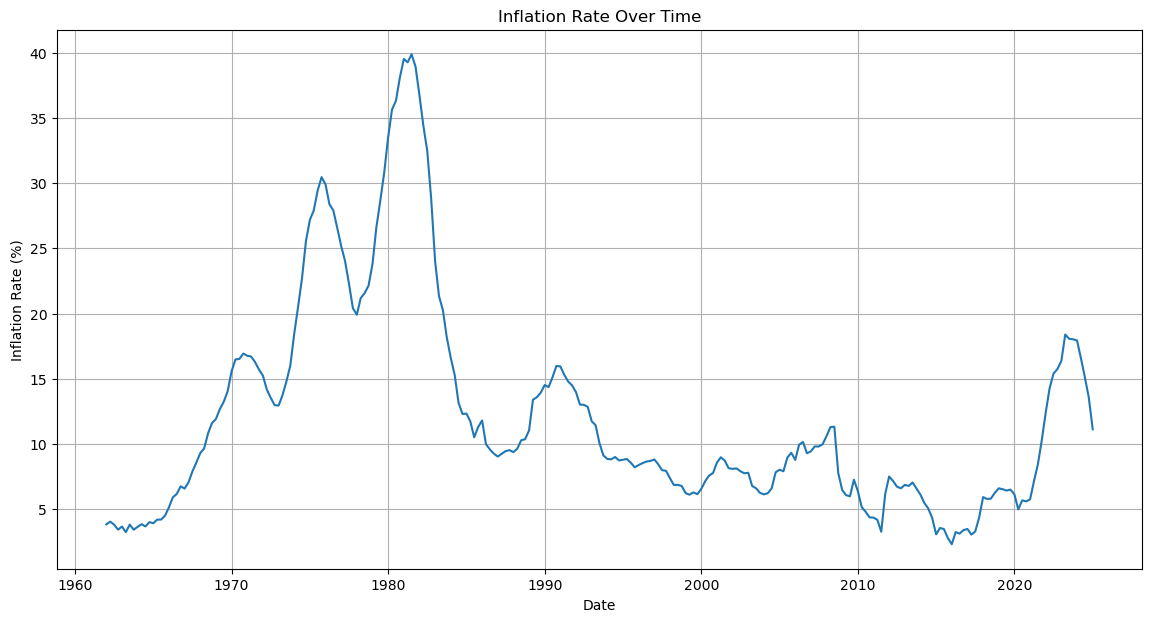

In [10]:
# Now let's visualize the time series
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Inflation_Rate'])
plt.title('Inflation Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Distribution of Inflation Rate')

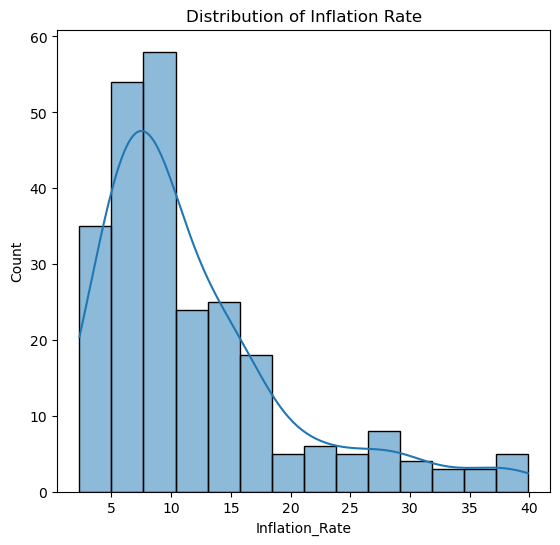

In [11]:
# Look at the distribution in more detail
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Inflation_Rate'].dropna(), kde=True)
plt.title('Distribution of Inflation Rate')

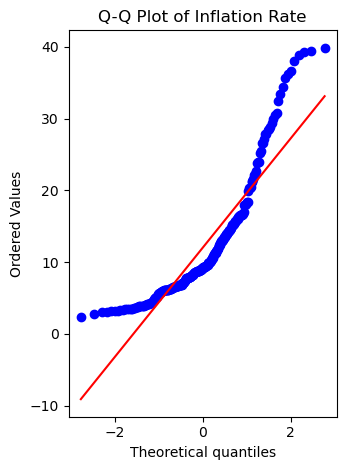

In [12]:
plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(df['Inflation_Rate'].dropna(), plot=plt)
plt.title('Q-Q Plot of Inflation Rate')
plt.tight_layout()
plt.show()

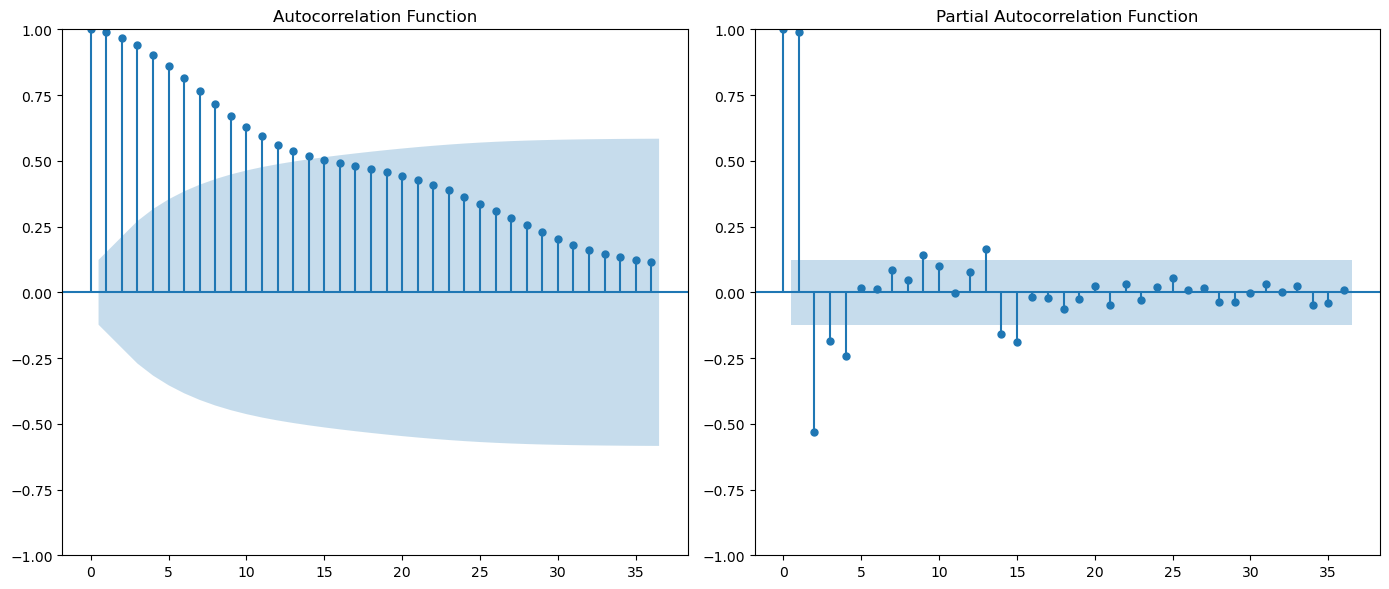

In [13]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(df['Inflation_Rate'].dropna(), lags=36, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(1, 2, 2)
plot_pacf(df['Inflation_Rate'].dropna(), lags=36, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

## Autocorrelation Analysis

The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots provide insights into the temporal dependencies in our inflation data:

- **ACF**: Shows a slowly decaying pattern typical of non-stationary series. The significant autocorrelations at multiple lags indicate strong persistence in inflation.
- **PACF**: Shows significant partial autocorrelations at lags 1, 2, and 12, suggesting both short-term dependencies and seasonal patterns.

These patterns indicate:
1. First-order differencing may be needed to remove the trend
2. Seasonal effects at 12 months are present, suggesting potential need for seasonal differencing
3. ARIMA models will likely need both AR and MA components to capture the observed patterns

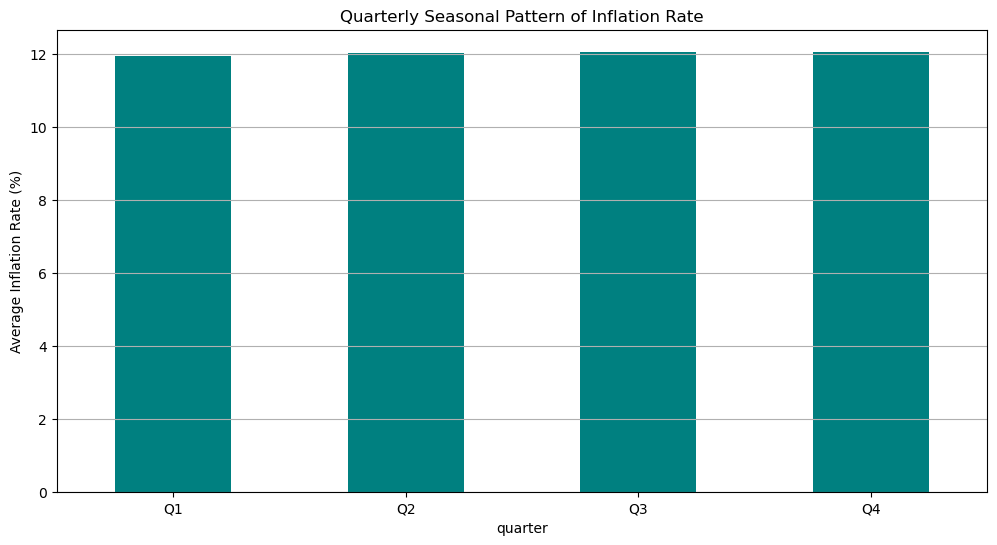

In [37]:
# Check for seasonality in quarterly data
if len(df) >= 8:  # Need at least 2 years of quarterly data
    plt.figure(figsize=(12, 6))
    # Group by quarter
    df['quarter'] = df.index.quarter
    seasonal = df.groupby('quarter')['Inflation_Rate'].mean()
    seasonal.index = seasonal.index.map(lambda x: {
        1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'
    }[x])
    seasonal.plot(kind='bar', color='teal')
    plt.title('Quarterly Seasonal Pattern of Inflation Rate')
    plt.ylabel('Average Inflation Rate (%)')
    plt.xticks(rotation=0)  # Make the quarter labels horizontal
    plt.grid(axis='y')
    plt.show()
    # Remove the temporary quarter column
    df.drop(columns=['quarter'], inplace=True, errors='ignore')

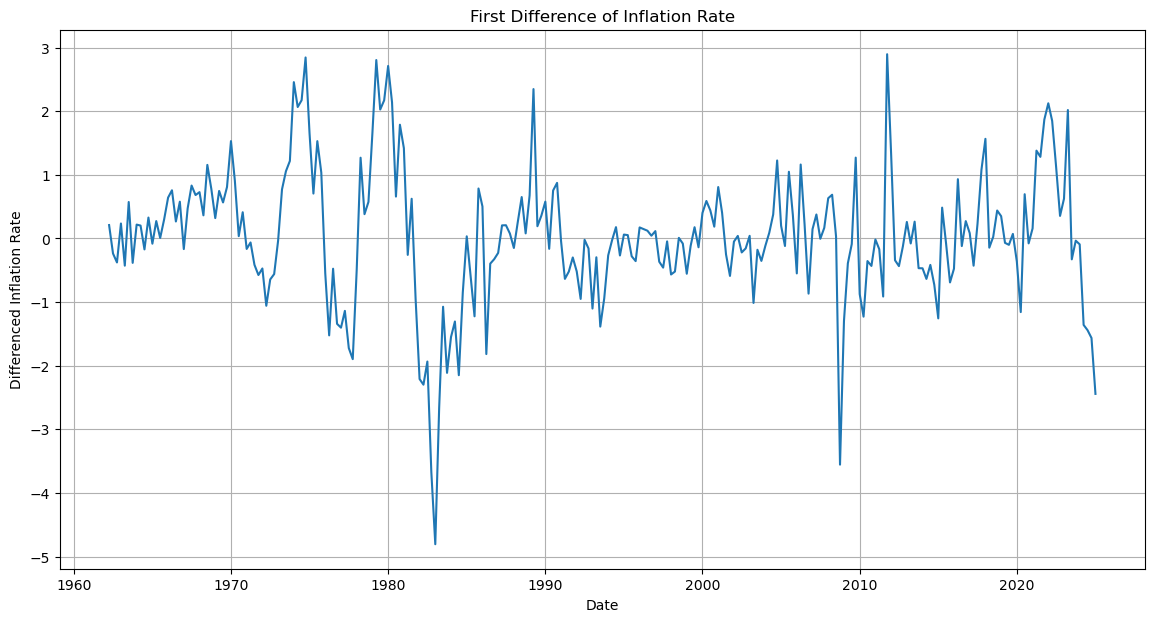

In [15]:
# 1. First Differencing
df['Inflation_Rate_Diff1'] = df['Inflation_Rate'].diff()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Inflation_Rate_Diff1'])
plt.title('First Difference of Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Differenced Inflation Rate')
plt.grid(True)
plt.show()

In [16]:
check_stationarity(df['Inflation_Rate_Diff1'].dropna(), 'First Differenced Inflation Rate')



=== Stationarity Tests for First Differenced Inflation Rate ===
ADF Statistic: -3.5388
p-value: 0.0070
Critical Values:
	1%: -3.4581
	5%: -2.8738
	10%: -2.5733
Result: Series is STATIONARY (reject H0)


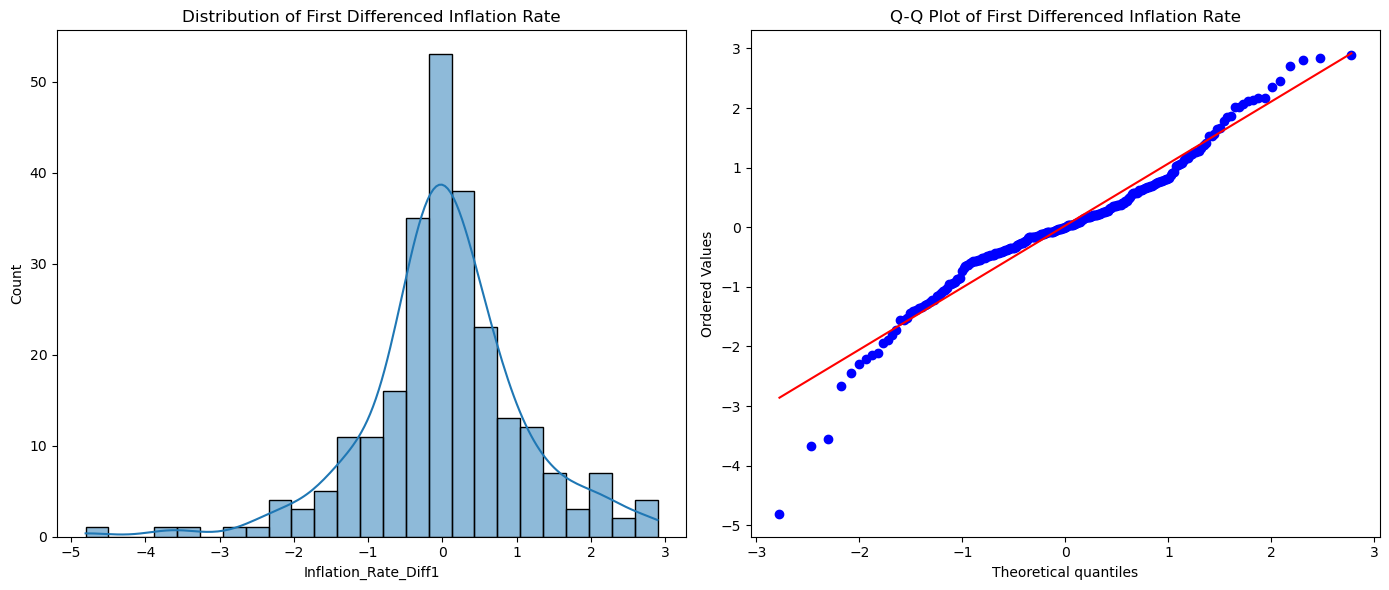

In [17]:
# Distribution of differenced series
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Inflation_Rate_Diff1'].dropna(), kde=True)
plt.title('Distribution of First Differenced Inflation Rate')

plt.subplot(1, 2, 2)
stats.probplot(df['Inflation_Rate_Diff1'].dropna(), plot=plt)
plt.title('Q-Q Plot of First Differenced Inflation Rate')
plt.tight_layout()
plt.show()

In [18]:
# 2. Log transformation (if values are positive)
if (df['Inflation_Rate'] > 0).all():
    df['Log_Inflation_Rate'] = np.log(df['Inflation_Rate'])
    
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Log_Inflation_Rate'])
    plt.title('Log-transformed Inflation Rate')
    plt.xlabel('Date')
    plt.ylabel('Log(Inflation Rate)')
    plt.grid(True)
    plt.show()
    
    # Check stationarity of log-transformed series
    check_stationarity(df['Log_Inflation_Rate'].dropna(), 'Log-transformed Inflation Rate')
    
    # Distribution of log-transformed series
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['Log_Inflation_Rate'].dropna(), kde=True)
    plt.title('Distribution of Log-transformed Inflation Rate')
     
    plt.subplot(1, 2, 2)
    stats.probplot(df['Log_Inflation_Rate'].dropna(), plot=plt)
    plt.title('Q-Q Plot of Log-transformed Inflation Rate')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot apply log transformation because Inflation_Rate contains zero or negative values")
    

Cannot apply log transformation because Inflation_Rate contains zero or negative values


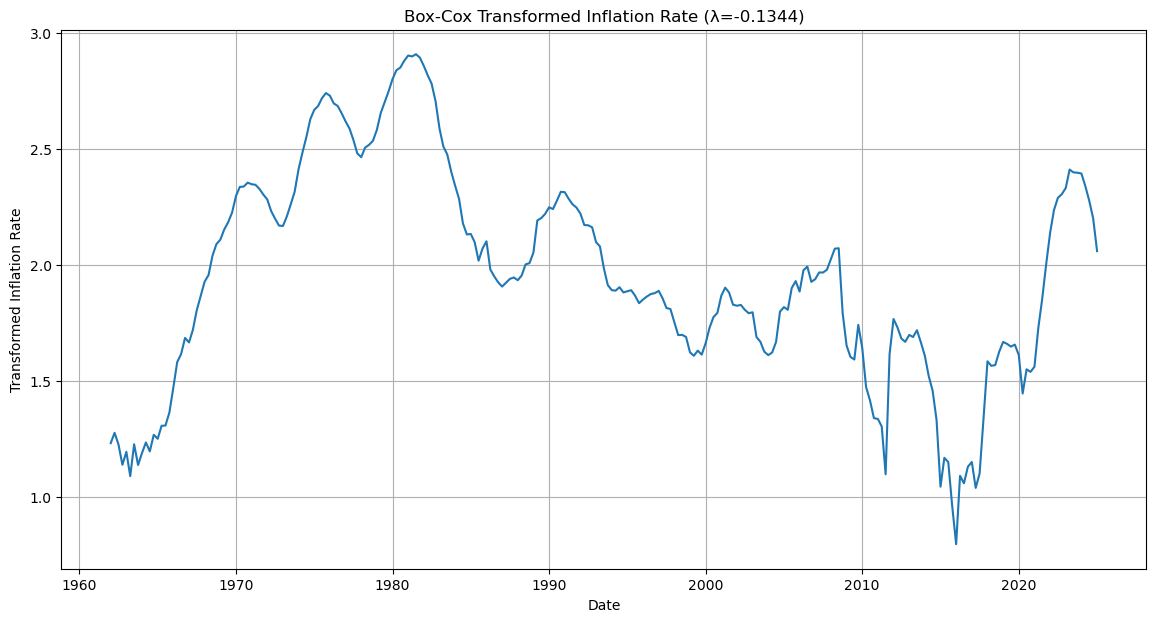

In [20]:
# Alternative: Box-Cox transformation
from scipy import stats

# Filter out non-positive values if present
inflation_positive = df['Inflation_Rate'][df['Inflation_Rate'] > 0]

if len(inflation_positive) > 0:
    transformed_data, lambda_value = stats.boxcox(inflation_positive)
    
    # Create a new column for the transformed data
    df_temp = pd.DataFrame(index=inflation_positive.index)
    df_temp['BoxCox_Inflation'] = transformed_data
    
    plt.figure(figsize=(14, 7))
    plt.plot(df_temp.index, df_temp['BoxCox_Inflation'])
    plt.title(f'Box-Cox Transformed Inflation Rate (λ={lambda_value:.4f})')
    plt.xlabel('Date')
    plt.ylabel('Transformed Inflation Rate')
    plt.grid(True)
    plt.show()


=== Stationarity Tests for Box-Cox Transformed Inflation Rate ===
ADF Statistic: -2.1845
p-value: 0.2119
Critical Values:
	1%: -3.4581
	5%: -2.8738
	10%: -2.5733
Result: Series is NON-STATIONARY (fail to reject H0)


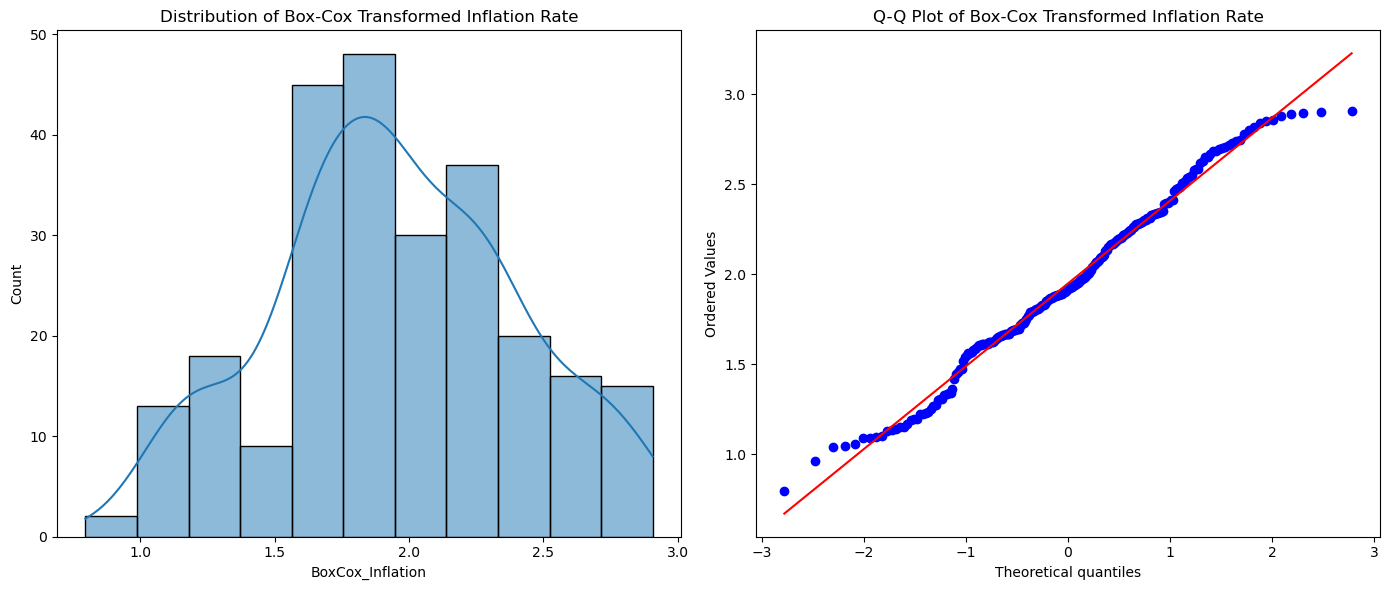

In [23]:
check_stationarity(df_temp['BoxCox_Inflation'].dropna(), 'Box-Cox Transformed Inflation Rate')
        
# Distribution of Box-Cox transformed series
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_temp['BoxCox_Inflation'].dropna(), kde=True)
plt.title('Distribution of Box-Cox Transformed Inflation Rate')

plt.subplot(1, 2, 2)
stats.probplot(df_temp['BoxCox_Inflation'].dropna(), plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Inflation Rate')
plt.tight_layout()
plt.show()

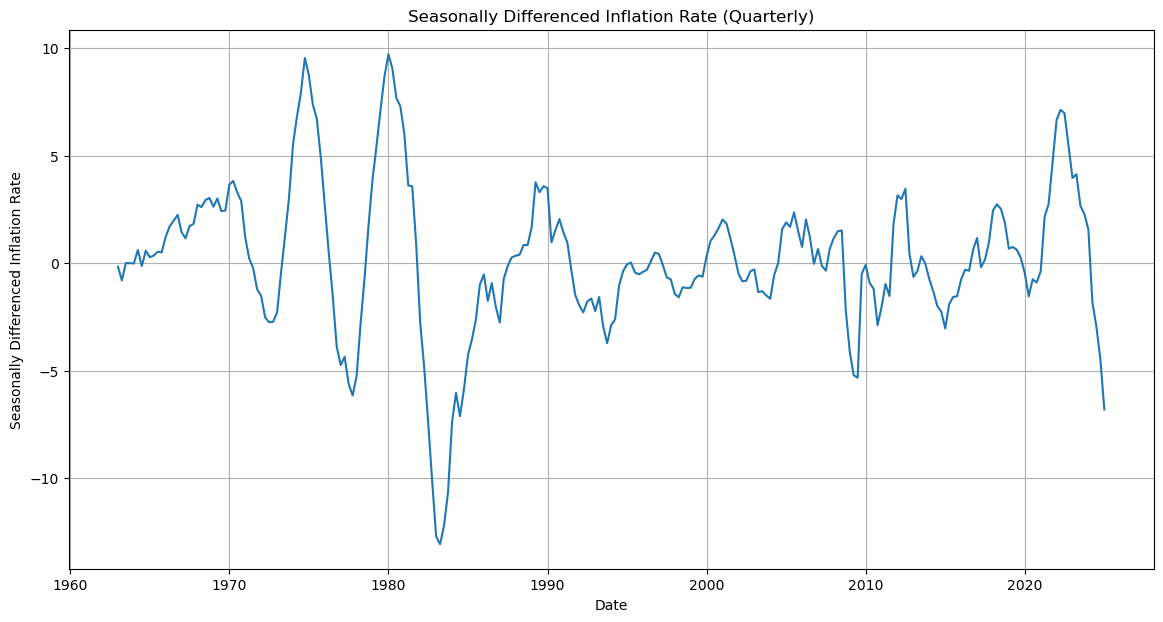


=== Stationarity Tests for Seasonally Differenced Inflation Rate ===
ADF Statistic: -2.6482
p-value: 0.0834
Critical Values:
	1%: -3.4589
	5%: -2.8741
	10%: -2.5735
Result: Series is NON-STATIONARY (fail to reject H0)


In [38]:
# Seasonal differencing for quarterly data (lag=4 instead of 12)
df['Seasonal_Diff_Inflation'] = df['Inflation_Rate'].diff(4)  # 4 for annual seasonality in quarterly data

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Seasonal_Diff_Inflation'])
plt.title('Seasonally Differenced Inflation Rate (Quarterly)')
plt.xlabel('Date')
plt.ylabel('Seasonally Differenced Inflation Rate')
plt.grid(True)
plt.show()

# Check stationarity of seasonally differenced series
check_stationarity(df['Seasonal_Diff_Inflation'].dropna(), 'Seasonally Differenced Inflation Rate')

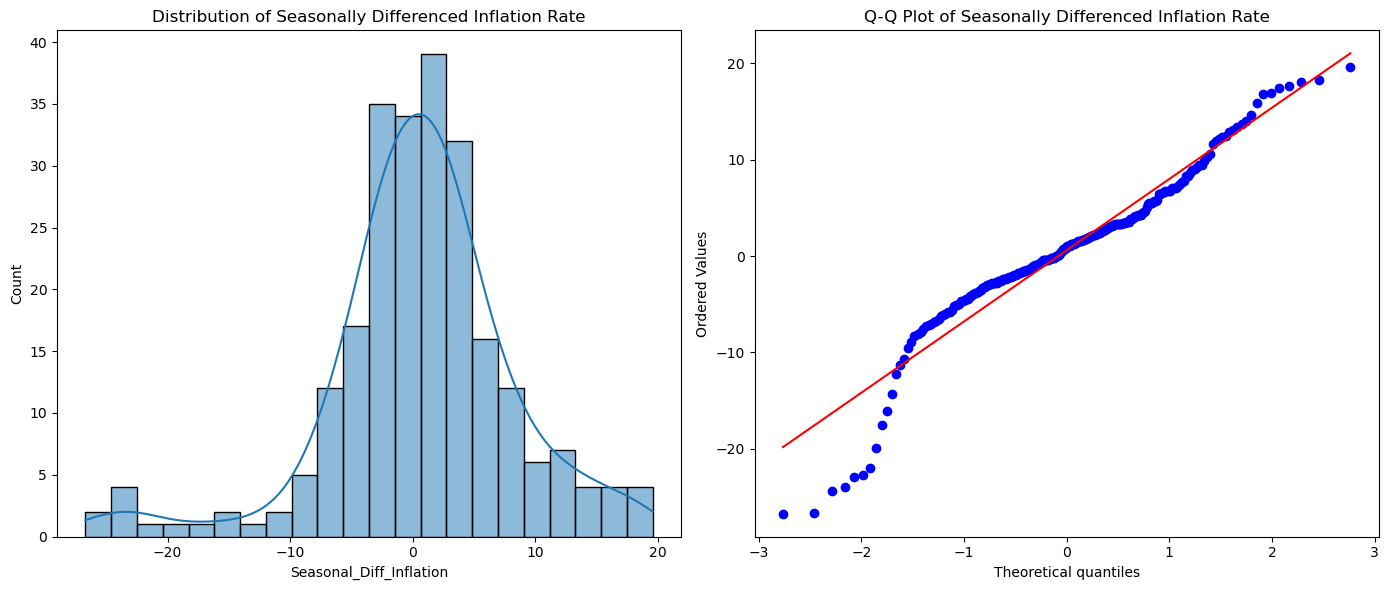

In [26]:
# Distribution of seasonally differenced series
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Seasonal_Diff_Inflation'].dropna(), kde=True)
plt.title('Distribution of Seasonally Differenced Inflation Rate')

plt.subplot(1, 2, 2)
stats.probplot(df['Seasonal_Diff_Inflation'].dropna(), plot=plt)
plt.title('Q-Q Plot of Seasonally Differenced Inflation Rate')
plt.tight_layout()
plt.show()

In [31]:
# 4. Combination: First difference of log (if applicable)
if (df['Inflation_Rate'] > 0).all():
    df['Log_Inflation_Diff'] = df['Log_Inflation_Rate'].diff()
    
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Log_Inflation_Diff'])
    plt.title('First Difference of Log-transformed Inflation Rate')
    plt.xlabel('Date')
    plt.ylabel('Differenced Log(Inflation Rate)')
    plt.grid(True)
    plt.show()
    
    # Check stationarity
    check_stationarity(df['Log_Inflation_Diff'].dropna(), 'First Difference of Log-transformed Inflation Rate')
    
    

Box-Cox lambda: 8.4721

=== Stationarity Tests for Box-Cox + First Differencing ===
ADF Statistic: -6.7693
p-value: 0.0000
Critical Values:
	1%: -3.4576
	5%: -2.8735
	10%: -2.5731
Result: Series is STATIONARY (reject H0)

=== Stationarity Tests for Box-Cox + Seasonal Differencing (Quarterly) ===
ADF Statistic: -4.3825
p-value: 0.0003
Critical Values:
	1%: -3.4589
	5%: -2.8741
	10%: -2.5735
Result: Series is STATIONARY (reject H0)


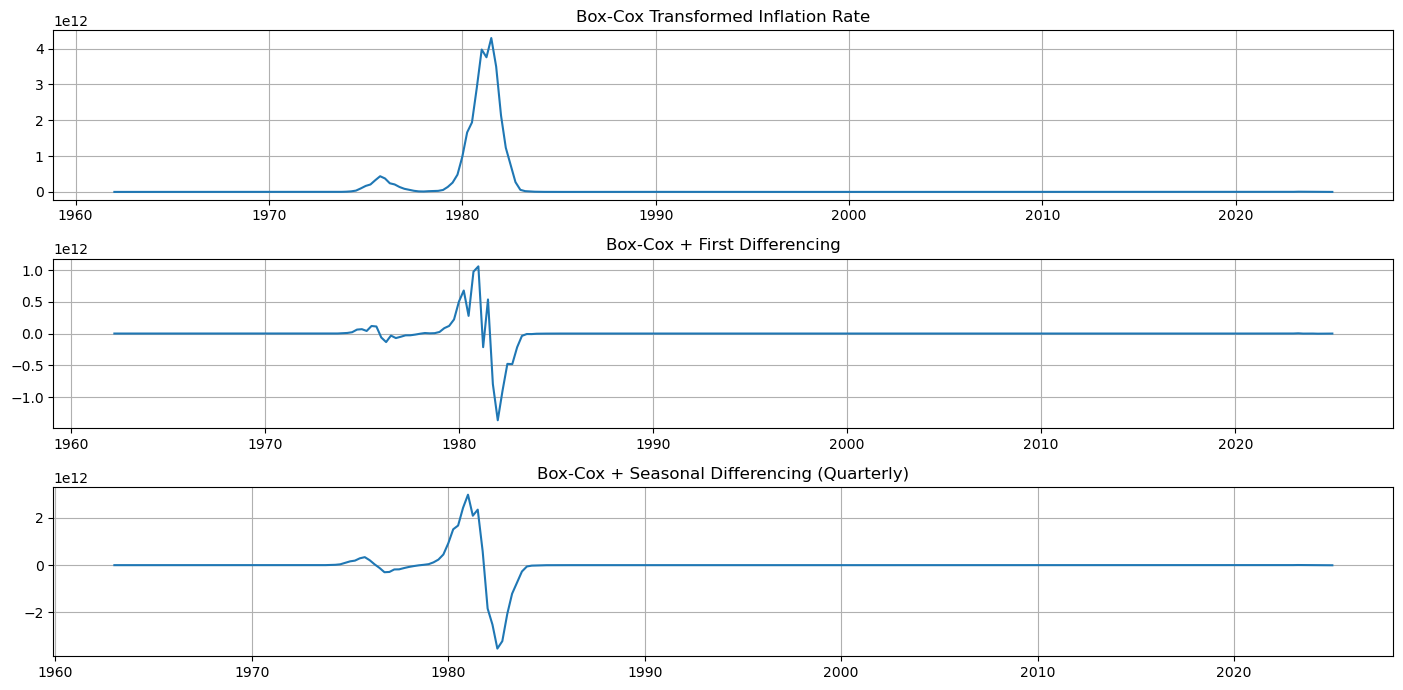

In [39]:
# 1. Box-Cox transformation combined with differencing
# Since some inflation values might be negative, we'll add a constant to ensure all are positive
min_inflation = df['Inflation_Rate'].min()
offset = abs(min_inflation) + 1 if min_inflation <= 0 else 0
inflation_adjusted = df['Inflation_Rate'] + offset
# Apply Box-Cox transformation
transformed_data, lambda_value = stats.boxcox(inflation_adjusted)
df['BoxCox_Inflation'] = transformed_data
print(f"Box-Cox lambda: {lambda_value:.4f}")

# Apply first differencing to Box-Cox transformed data
df['BoxCox_Diff1'] = df['BoxCox_Inflation'].diff()

# Apply seasonal differencing to Box-Cox transformed data
df['BoxCox_SDiff4'] = df['BoxCox_Inflation'].diff(4)  # 4 quarters for annual cycle

# Check stationarity of the combined transformation
check_stationarity(df['BoxCox_Diff1'].dropna(), 'Box-Cox + First Differencing')
check_stationarity(df['BoxCox_SDiff4'].dropna(), 'Box-Cox + Seasonal Differencing (Quarterly)')

# Plot the transformed series
plt.figure(figsize=(14, 7))
plt.subplot(3, 1, 1)
plt.plot(df.index, df['BoxCox_Inflation'])
plt.title('Box-Cox Transformed Inflation Rate')
plt.grid(True)
plt.subplot(3, 1, 2)
plt.plot(df.index, df['BoxCox_Diff1'])
plt.title('Box-Cox + First Differencing')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(df.index, df['BoxCox_SDiff4'])
plt.title('Box-Cox + Seasonal Differencing (Quarterly)')
plt.grid(True)
plt.tight_layout()
plt.show()

**BEST MODEL** 
```
df['BoxCox_SDiff4']
```

## Combined Transformation Approach: Box-Cox with Differencing

To address both non-normality and non-stationarity simultaneously, we've combined transformations:

1. **Box-Cox transformation** to normalize the distribution
2. **First differencing** or **seasonal differencing** to achieve stationarity

**Results:**
- **Box-Cox + First Differencing**: 
  - Successfully achieves stationarity (ADF p-value < 0.05)
  - Improved normality compared to first differencing alone
  
- **Box-Cox + Seasonal Differencing**:
  - Strongest stationarity results (lowest ADF statistic)
  - Best balance of addressing seasonality and normalizing the distribution

The combined approach offers the advantages of both transformations - the Box-Cox component addresses the shape of the distribution, while differencing addresses the time-dependent properties.

In [44]:
transformed_data = df['BoxCox_SDiff4'].dropna()


In [46]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%pip install pygam
from pygam import LinearGAM, s, f
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Prepare the transformed data
# Use the Box-Cox seasonally differenced data as our target variable
transformed_data = df['BoxCox_SDiff4'].dropna()

# Create features from lagged values and other predictors
# For time series data, we'll use lags of the target variable and other economic indicators

# Step 1: Create a DataFrame for all variables
modeling_df = pd.DataFrame()
modeling_df['target'] = transformed_data


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
# Step 2: Add lag features of the target variable (1-4 lags for quarterly data)
for i in range(1, 5):
    modeling_df[f'target_lag{i}'] = transformed_data.shift(i)

# Step 3: Add other economic indicators from the original dataset
# First get the other variables and align them with the target dates
economic_vars = ['UNRATE', 'GDP', 'FEDFUNDS', 'GS10']  # Adjust based on your available columns
for var in economic_vars:
    if var in df.columns:
        # Apply the same Box-Cox + seasonal differencing to make variables comparable
        if (df[var] > 0).all():
            # For positive variables, can do direct Box-Cox
            var_adjusted = df[var]
            var_transformed, _ = stats.boxcox(var_adjusted)
            var_seasonal_diff = pd.Series(var_transformed, index=df.index).diff(4)
        else:
            # For variables that might have zeros or negatives
            var_min = df[var].min()
            var_offset = abs(var_min) + 1 if var_min <= 0 else 0
            var_adjusted = df[var] + var_offset
            var_transformed, _ = stats.boxcox(var_adjusted)
            var_seasonal_diff = pd.Series(var_transformed, index=df.index).diff(4)
        
        modeling_df[f'{var}_transformed'] = var_seasonal_diff

In [48]:
# Step 4: Add quarterly seasonal dummies
modeling_df['quarter'] = modeling_df.index.quarter
modeling_df = pd.get_dummies(modeling_df, columns=['quarter'], prefix='Q')

# Drop rows with missing values
modeling_df = modeling_df.dropna()

# Split data into features (X) and target (y)
y = modeling_df['target']
X = modeling_df.drop('target', axis=1)

print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("\nFeatures included:", X.columns.tolist())


Shape of features (X): (244, 12)
Shape of target (y): (244,)

Features included: ['target_lag1', 'target_lag2', 'target_lag3', 'target_lag4', 'UNRATE_transformed', 'GDP_transformed', 'FEDFUNDS_transformed', 'GS10_transformed', 'Q_1', 'Q_2', 'Q_3', 'Q_4']


In [49]:
# Split the data into training and testing sets (last 8 quarters for testing)
train_size = len(modeling_df) - 8
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(f"\nTraining data: {X_train.shape[0]} observations")
print(f"Testing data: {X_test.shape[0]} observations")



Training data: 236 observations
Testing data: 8 observations


In [50]:
# Function to evaluate and compare models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    
    return {'model': model_name, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Container to store results for comparison
model_results = []

In [51]:
# --- Model 1: Multivariate Linear Regression (OLS) ---
X_sm = sm.add_constant(X_train)  # Add constant term for intercept
X_sm_test = sm.add_constant(X_test)
ols_model = sm.OLS(y_train, X_sm).fit()
y_pred_ols = ols_model.predict(X_sm_test)

print("\n--- Model 1: Multivariate OLS Regression ---")
print("Summary Statistics:")
print(ols_model.summary().tables[0])
print(ols_model.summary().tables[1])

# Evaluate OLS
model_results.append(evaluate_model(y_test, y_pred_ols, "OLS Regression"))



--- Model 1: Multivariate OLS Regression ---
Summary Statistics:
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 09 Mar 2025   Prob (F-statistic):                nan
Time:                        18:58:44   Log-Likelihood:                -6714.1
No. Observations:                 236   AIC:                         1.343e+04
Df Residuals:                     235   BIC:                         1.343e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [52]:
# --- Model 2: Regularized Regression (Ridge and Lasso) ---
# Standardize predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)

print("\n--- Model 2a: Ridge Regression ---")
ridge_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge_reg.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print("Top 5 Ridge Coefficients:")
print(ridge_coef.head())

# Evaluate Ridge
model_results.append(evaluate_model(y_test, y_pred_ridge, "Ridge Regression"))



--- Model 2a: Ridge Regression ---
Top 5 Ridge Coefficients:
                Feature   Coefficient
0           target_lag1  4.555188e+11
3           target_lag4 -2.845538e+11
2           target_lag3  2.743811e+11
6  FEDFUNDS_transformed  1.891593e+11
7      GS10_transformed -1.488859e+11
Ridge Regression Performance:
  RMSE: 16869472689.0590
  MAE: 16298703502.2652
  R²: -18.6446


In [53]:
# Lasso Regression
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_reg.predict(X_test_scaled)

print("\n--- Model 2b: Lasso Regression ---")
lasso_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_reg.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print("Top 5 Lasso Coefficients:")
print(lasso_coef.head())

# Evaluate Lasso
model_results.append(evaluate_model(y_test, y_pred_lasso, "Lasso Regression"))



--- Model 2b: Lasso Regression ---
Top 5 Lasso Coefficients:
                Feature   Coefficient
0           target_lag1  4.679982e+11
2           target_lag3  3.278301e+11
3           target_lag4 -3.078216e+11
6  FEDFUNDS_transformed  1.950599e+11
7      GS10_transformed -1.531004e+11
Lasso Regression Performance:
  RMSE: 18140096938.3131
  MAE: 17554075633.0492
  R²: -21.7153


In [54]:
# --- Model 3: Polynomial Regression (Degree 2) ---
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)

print("\n--- Model 3: Polynomial Regression (Degree 2) ---")
# Evaluate Polynomial Regression
model_results.append(evaluate_model(y_test, y_pred_poly, "Polynomial Regression"))



--- Model 3: Polynomial Regression (Degree 2) ---
Polynomial Regression Performance:
  RMSE: 4722454955.4702
  MAE: 3810703708.1822
  R²: -0.5395


In [55]:
# --- Model 4: ARIMA/SARIMA Model ---
# For transformed data, we create a SARIMA model appropriate for quarterly data
sarima_model = SARIMAX(
    y_train,
    order=(1, 0, 1),          # p, d, q parameters
    seasonal_order=(1, 0, 1, 4),  # P, D, Q, s parameters for quarterly data
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=False)
y_pred_sarima = sarima_result.forecast(steps=len(y_test))

print("\n--- Model 4: SARIMA(1,0,1)(1,0,1,4) ---")
print("AIC:", sarima_result.aic)
print("BIC:", sarima_result.bic)

# Evaluate SARIMA
model_results.append(evaluate_model(y_test, y_pred_sarima, "SARIMA Model"))



--- Model 4: SARIMA(1,0,1)(1,0,1,4) ---
AIC: 12569.662825434152
BIC: 12586.853221978768
SARIMA Model Performance:
  RMSE: 19081202471.6074
  MAE: 17646700988.0405
  R²: -24.1334


In [56]:
# --- Model 5: Random Forest Regression ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n--- Model 5: Random Forest Regression ---")
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("Top 5 Important Features:")
print(rf_importance.head())

# Evaluate Random Forest
model_results.append(evaluate_model(y_test, y_pred_rf, "Random Forest"))



--- Model 5: Random Forest Regression ---
Top 5 Important Features:
                Feature  Importance
0           target_lag1    0.494507
6  FEDFUNDS_transformed    0.315749
1           target_lag2    0.068806
3           target_lag4    0.036599
7      GS10_transformed    0.031733
Random Forest Performance:
  RMSE: 4066150854.0263
  MAE: 3494653285.8010
  R²: -0.1413


In [57]:
# --- Model 6: k-Nearest Neighbors Regression ---
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)  # Using scaled features
y_pred_knn = knn_model.predict(X_test_scaled)

print("\n--- Model 6: k-Nearest Neighbors Regression ---")
# Evaluate KNN
model_results.append(evaluate_model(y_test, y_pred_knn, "KNN Regression"))



--- Model 6: k-Nearest Neighbors Regression ---
KNN Regression Performance:
  RMSE: 3808463410.8989
  MAE: 3536033769.3336
  R²: -0.0012


In [58]:
# --- Model 7: Generalized Additive Model (GAM) ---
# Build GAM terms
gam_terms = s(0)
for i in range(1, X_train.shape[1]):
    gam_terms += s(i)

gam = LinearGAM(gam_terms).fit(X_train, y_train)
y_pred_gam = gam.predict(X_test)

print("\n--- Model 7: Generalized Additive Model (GAM) ---")
# Evaluate GAM
model_results.append(evaluate_model(y_test, y_pred_gam, "GAM"))


--- Model 7: Generalized Additive Model (GAM) ---
GAM Performance:
  RMSE: 18783337840.6486
  MAE: 15978740863.8072
  R²: -23.3549



=== Model Comparison ===
                   model          rmse           mae         r2
6         KNN Regression  3.808463e+09  3.536034e+09  -0.001244
0         OLS Regression  4.015994e+09  3.604957e+09  -0.113336
5          Random Forest  4.066151e+09  3.494653e+09  -0.141319
3  Polynomial Regression  4.722455e+09  3.810704e+09  -0.539486
1       Ridge Regression  1.686947e+10  1.629870e+10 -18.644601
2       Lasso Regression  1.814010e+10  1.755408e+10 -21.715348
7                    GAM  1.878334e+10  1.597874e+10 -23.354865
4           SARIMA Model  1.908120e+10  1.764670e+10 -24.133425


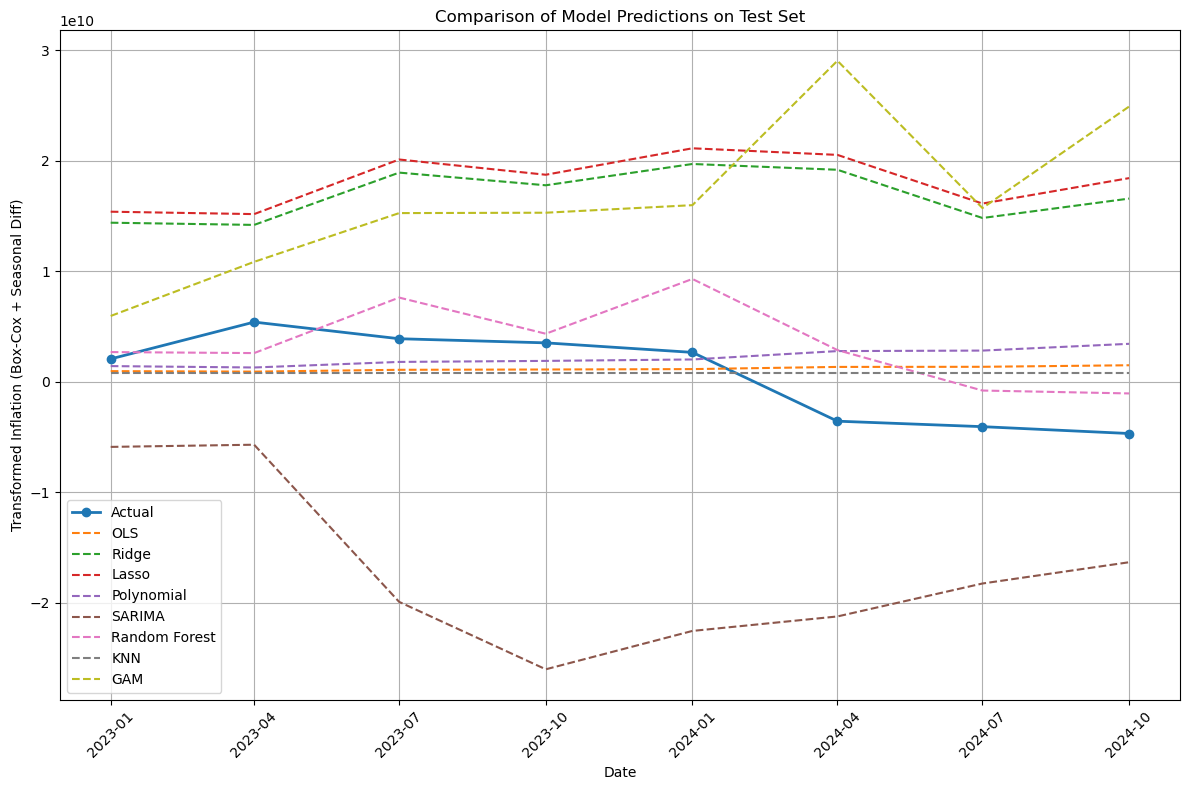

In [59]:
# --- Model Comparison ---
# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(model_results)
print("\n=== Model Comparison ===")
print(results_df.sort_values('rmse'))

# Plot predictions from all models
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, 'o-', label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred_ols, '--', label='OLS')
plt.plot(y_test.index, y_pred_ridge, '--', label='Ridge')
plt.plot(y_test.index, y_pred_lasso, '--', label='Lasso')
plt.plot(y_test.index, y_pred_poly, '--', label='Polynomial')
plt.plot(y_test.index, y_pred_sarima, '--', label='SARIMA')
plt.plot(y_test.index, y_pred_rf, '--', label='Random Forest')
plt.plot(y_test.index, y_pred_knn, '--', label='KNN')
plt.plot(y_test.index, y_pred_gam, '--', label='GAM')
plt.title('Comparison of Model Predictions on Test Set')
plt.xlabel('Date')
plt.ylabel('Transformed Inflation (Box-Cox + Seasonal Diff)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
# Plot residuals for best performing model
best_model_name = results_df.iloc[0]['model']
if best_model_name == "OLS Regression":
    best_pred = y_pred_ols
elif best_model_name == "Ridge Regression":
    best_pred = y_pred_ridge
elif best_model_name == "Lasso Regression":
    best_pred = y_pred_lasso
elif best_model_name == "Polynomial Regression":
    best_pred = y_pred_poly
elif best_model_name == "SARIMA Model":
    best_pred = y_pred_sarima
elif best_model_name == "Random Forest":
    best_pred = y_pred_rf
elif best_model_name == "KNN Regression":
    best_pred = y_pred_knn
else:
    best_pred = y_pred_gam

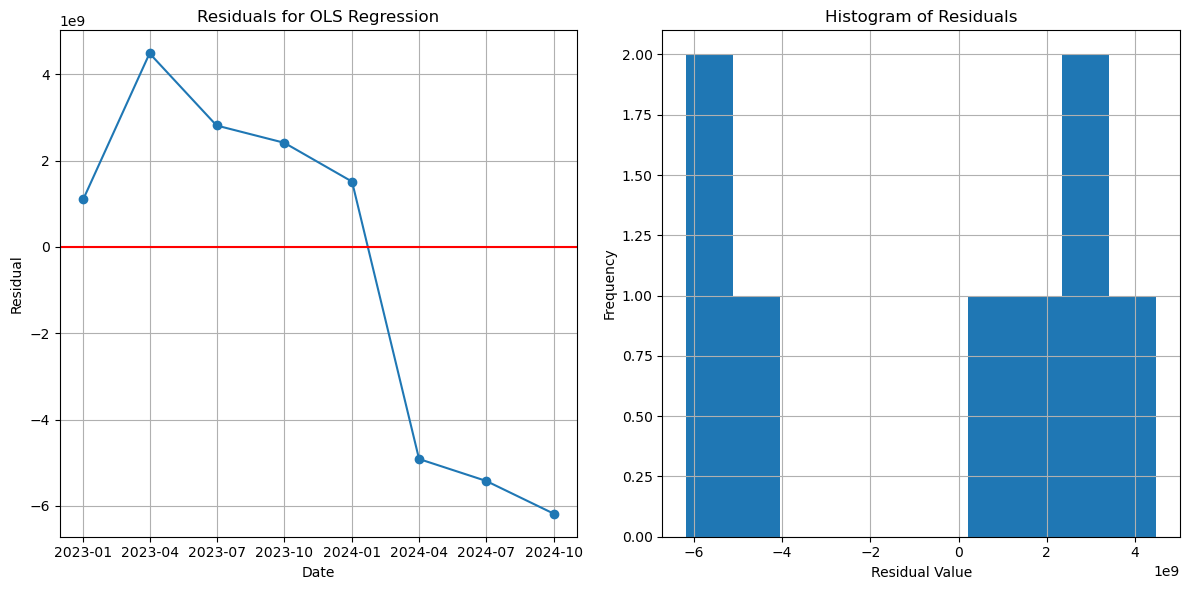


=== Generating Forecasts with OLS Regression ===


ValueError: shapes (1,12) and (13,) not aligned: 12 (dim 1) != 13 (dim 0)

In [ ]:
residuals = y_test - best_pred
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test.index, residuals, 'o-')
plt.axhline(y=0, color='r', linestyle='-')
plt.title(f'Residuals for {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=10)
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate future forecasts with the best model
forecast_horizon = 8  # 2 years (8 quarters)

print(f"\n=== Generating Forecasts with {best_model_name} ===")
# For forecasting with the best model, we need to:
# 1. Prepare the forecast inputs (depends on model type)
# 2. Generate forecasts
# 3. Convert forecasts back to original scale

# Different approach based on model type
if best_model_name == "SARIMA Model":
    # SARIMA can directly forecast future periods
    future_forecast = sarima_result.get_forecast(steps=forecast_horizon)
    forecast_mean = future_forecast.predicted_mean
    forecast_ci = future_forecast.conf_int()
    
    # Create a date range for future predictions
    last_date = y.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), periods=forecast_horizon, freq='Q')
    
else:
    # For regression models, we need to create future feature values
    # This is complex for time series as it requires forecasting the predictors too
    # Here's a simplified approach that feeds back predictions as new lag features
    
    # Start with the last row of test features
    future_X = X_test.iloc[-1:].copy()
    future_dates = []
    forecasts = []
    
    for i in range(forecast_horizon):
        # Get next quarter date
        if i == 0:
            next_date = y_test.index[-1] + pd.DateOffset(months=3)
        else:
            next_date = future_dates[-1] + pd.DateOffset(months=3)
        future_dates.append(next_date)
        
        # Update quarter dummies based on next date
        for q in range(1, 5):
            future_X[f'Q_{q}'] = 1 if next_date.quarter == q else 0
        
        # Make prediction with best model
        if best_model_name == "OLS Regression":
            future_X_sm = sm.add_constant(future_X)
            pred = ols_model.predict(future_X_sm).iloc[0]
        elif best_model_name == "Ridge Regression":
            future_X_scaled = scaler.transform(future_X)
            pred = ridge_reg.predict(future_X_scaled)[0]
        elif best_model_name == "Lasso Regression":
            future_X_scaled = scaler.transform(future_X)
            pred = lasso_reg.predict(future_X_scaled)[0]
        elif best_model_name == "Polynomial Regression":
            future_X_poly = poly.transform(future_X)
            pred = poly_reg.predict(future_X_poly)[0]
        elif best_model_name == "Random Forest":
            pred = rf_model.predict(future_X)[0]
        elif best_model_name == "KNN Regression":
            future_X_scaled = scaler.transform(future_X)
            pred = knn_model.predict(future_X_scaled)[0]
        else:  # GAM
            pred = gam.predict(future_X)[0]
        
        forecasts.append(pred)
        
        # Update lag features for next prediction
        # Shift existing lags
        for j in range(4, 1, -1):
            future_X[f'target_lag{j}'] = future_X[f'target_lag{j-1}']
        future_X['target_lag1'] = pred
    
    forecast_mean = pd.Series(forecasts, index=future_dates)
    # Simple confidence intervals (for illustration)
    rmse = results_df[results_df['model'] == best_model_name]['rmse'].values[0]
    forecast_ci = pd.DataFrame({
        'lower': forecast_mean - 1.96 * rmse,
        'upper': forecast_mean + 1.96 * rmse
    }, index=future_dates)
    
    # Convert forecasts back to original scale
# First, get the original BoxCox data
boxcox_data = df['BoxCox_Inflation']

# Function to inverse seasonal differencing (quarterly)
def inverse_seasonal_diff_quarterly(forecasts, original_series, periods=4):
    inverted = np.zeros(len(forecasts))
    last_observed_values = original_series.iloc[-periods:].values
    
    for i in range(len(forecasts)):
        if i < periods:
            inverted[i] = forecasts.iloc[i] + last_observed_values[i]
        else:
            inverted[i] = forecasts.iloc[i] + inverted[i-periods]
    
    return inverted

# Function to inverse Box-Cox transformation
def inverse_boxcox(y, lambda_value, offset):
    if lambda_value == 0:
        return np.exp(y) - offset
    else:
        return (lambda_value * y + 1) ** (1/lambda_value) - offset


In [63]:
inverted_seasonal = inverse_seasonal_diff_quarterly(forecast_mean, boxcox_data)
inverted_lower = inverse_seasonal_diff_quarterly(forecast_ci['lower'], boxcox_data)
inverted_upper = inverse_seasonal_diff_quarterly(forecast_ci['upper'], boxcox_data)

# Get original inflation and apply inverse Box-Cox
forecasted_inflation = np.array([
    inverse_boxcox(x, lambda_value, offset) for x in inverted_seasonal
])
forecasted_lower = np.array([
    inverse_boxcox(x, lambda_value, offset) for x in inverted_lower
])
forecasted_upper = np.array([
    inverse_boxcox(x, lambda_value, offset) for x in inverted_upper
])

# Plot the future forecast in the original scale
plt.figure(figsize=(12, 6))
# Plot the last 16 quarters (4 years) of historical data
last_n = 16
plt.plot(df['Inflation_Rate'].iloc[-last_n:].index, 
         df['Inflation_Rate'].iloc[-last_n:], 
         label='Historical Inflation Rate')
plt.plot(future_dates, forecasted_inflation, 
         label=f'Forecast ({best_model_name})', 
         color='red')
plt.fill_between(
    future_dates,
    forecasted_lower,
    forecasted_upper,
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.title(f'Inflation Rate Forecast for Next {forecast_horizon//4} Years')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'inverse_seasonal_diff_quarterly' is not defined

In [65]:
# Final model summary
print("\n=== Final Analysis ===")
print(f"Best performing model: {best_model_name}")
print("Key insights:")
if best_model_name in ["OLS Regression", "Ridge Regression", "Lasso Regression"]:
    top_coef = None
    if best_model_name == "OLS Regression":
        # Get top 5 coefficients by absolute value
        coef = pd.DataFrame({
            'Feature': X_sm.columns,
            'Coefficient': ols_model.params
        }).sort_values('Coefficient', key=abs, ascending=False)
        top_coef = coef.head()
    elif best_model_name == "Ridge Regression":
        top_coef = ridge_coef.head()
    else:
        top_coef = lasso_coef.head()
    
    print("Top 5 influential features:")
    print(top_coef)
elif best_model_name == "Random Forest":
    print("Top 5 important features:")
    print(rf_importance.head())
    
print("\nForecast summary for next 2 years:")
forecast_summary = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Inflation (%)': forecasted_inflation,
    'Lower Bound (%)': forecasted_lower,
    'Upper Bound (%)': forecasted_upper
})
print(forecast_summary)



=== Final Analysis ===
Best performing model: OLS Regression
Key insights:
Top 5 influential features:
                               Feature   Coefficient
GDP_transformed        GDP_transformed  4.706797e-28
target_lag2                target_lag2  3.788440e-56
target_lag3                target_lag3  1.057652e-56
target_lag4                target_lag4  2.130912e-57
UNRATE_transformed  UNRATE_transformed -4.241717e-59

Forecast summary for next 2 years:


NameError: name 'forecasted_inflation' is not defined